In [59]:
# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

import numpy as np
import jax.numpy as jnp
import jax
from jax import random
import matplotlib.pyplot as plt
import networkx as nx

import numpyro
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoNormal
import numpyro.distributions as dist

import src.utils as utils



In [60]:
# read layers file

layers = {}
with open('Data/cs_aarhus/CS-Aarhus_layers.txt', 'r') as f:
    # Skip header
    next(f)
    for line in f:
        layer_id_str, layer_label = line.strip().split()
        layer_id = int(layer_id_str)
        layers[layer_id] = layer_label

print (layers)

# read nodes file
idx_to_node = []
with open('Data/cs_aarhus/CS-Aarhus_nodes.txt', 'r') as f:
    next(f)  # skip header
    for line in f:
        node_id_str, node_label = line.strip().split()
        node_id = int(node_id_str)
        idx_to_node.append(node_id)

node_to_idx = {node_id: i for i, node_id in enumerate(idx_to_node)}
num_nodes = len(idx_to_node)

{1: 'lunch', 2: 'facebook', 3: 'coauthor', 4: 'leisure', 5: 'work'}


In [61]:
# read edgeslist files and creat adjacency matrices

adjacency_matrices = [
        jnp.zeros((num_nodes, num_nodes), dtype=jnp.float32)
        for _ in range(5)
    ]

with open('Data/cs_aarhus/CS-Aarhus_multiplex.edges', 'r') as f:
        for line in f:
            # Each line looks like: layerID node1 node2 weight
            parts = line.strip().split()
            lay = int(parts[0])
            n1 = int(parts[1])
            n2 = int(parts[2])
            w  = float(parts[3])  # always 1 according to the description

            # Convert node IDs from 1-based to 0-based for indexing
            row = node_to_idx[n1]
            col = node_to_idx[n2]
            layer_idx = lay - 1   # also 0-based

            # Since it's undirected, set both [n1,n2] and [n2,n1]
            # jax.numpy arrays are immutable, so we use the ".at[].set()" syntax
            adjacency_matrices[layer_idx] = adjacency_matrices[layer_idx].at[row, col].set(w)
            adjacency_matrices[layer_idx] = adjacency_matrices[layer_idx].at[col, row].set(w)



In [63]:

for i in range(5):
    print("-" * 40)
    print(f"Layer {i+1}: {layers[i+1]}")
    print("n_edge:", adjacency_matrices[i].sum()/2)
    deg = adjacency_matrices[i].sum(axis=1)
    avg_deg = deg[deg > 0].mean()
    print("avg_deg (>0):", avg_deg)
    print("ave_deg:", adjacency_matrices[i].sum(axis=1).mean())
    print("-" * 40)


----------------------------------------
Layer 1: lunch
n_edge: 193.0
avg_deg (>0): 6.433334
ave_deg: 6.3278685
----------------------------------------
----------------------------------------
Layer 2: facebook
n_edge: 124.0
avg_deg (>0): 7.75
ave_deg: 4.0655737
----------------------------------------
----------------------------------------
Layer 3: coauthor
n_edge: 21.0
avg_deg (>0): 1.68
ave_deg: 0.68852454
----------------------------------------
----------------------------------------
Layer 4: leisure
n_edge: 88.0
avg_deg (>0): 3.7446806
ave_deg: 2.8852458
----------------------------------------
----------------------------------------
Layer 5: work
n_edge: 194.0
avg_deg (>0): 6.466667
ave_deg: 6.3606553
----------------------------------------


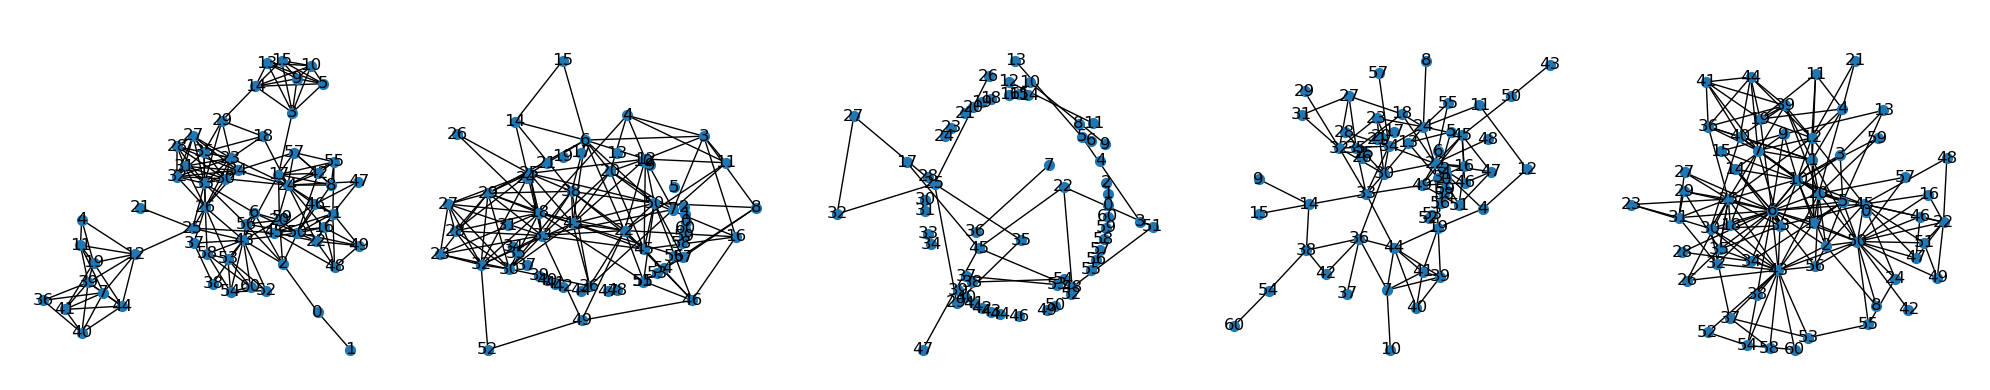

In [86]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i in range(5):
    G = nx.from_numpy_array(np.array(adjacency_matrices[i]))
    # pos = nx.circular_layout(G)
    pos = nx.kamada_kawai_layout(G)
    # pos = nx.random_layout(G, seed=42)
    nx.draw_networkx(
        G,
        pos=pos,
        ax=axes[i],
        node_size=50,
        with_labels=True
    )
    axes[i].set_title(f"{layers[i+1]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [67]:
# get triu values

triu_values = []
triu_indices = jnp.triu_indices(n=num_nodes, k=1)
for i in range(5):
    triu_values.append(adjacency_matrices[i][triu_indices])

triu_values = jnp.array(triu_values)
print(triu_values.shape)

(5, 1830)


In [138]:

def multi_model(triu_vals, n=num_nodes, K=2):

    n_layers = triu_vals.shape[0]

    # ------------------------
    # Hyper-priors (hierarchical)
    # ------------------------
    mu0 = numpyro.sample("mu0", dist.Normal(0.0, 1.0))
    mu1 = numpyro.sample("mu1", dist.Normal(0.0, 1.0))
    
    sigma0 = numpyro.sample("sigma0", dist.Exponential(1.0))  # scale for theta0
    sigma1 = numpyro.sample("sigma1", dist.Exponential(1.0))  # scale for theta1

     # We have n_layers+1 sets of (theta0_k, theta1_k):
    #   k=0 for the *latent* (unobserved) network
    #   k=1..L for the observed networks
    theta0 = []
    theta1 = []
    for k in range(n_layers+1):
        t0_k_nrm = numpyro.sample(f"theta0_{k}_nrm", dist.Normal(0.0, 1.0))
        t0_k = numpyro.deterministic(f"theta0_{k}", t0_k_nrm * sigma0 + mu0)
        # t1_k = numpyro.sample(f"theta1_{k}", dist.Normal(mu1, sigma1))
        t1_k_nrm = numpyro.sample(f"theta1_{k}_nrm", dist.Normal(0.0, 1.0))
        t1_k = numpyro.deterministic(f"theta1_{k}", t1_k_nrm * sigma1 + mu1)
        # t1_k = t1_k * sigma1 + mu1
        theta0.append(t0_k)
        theta1.append(t1_k)

    # ------------------------
    # Shared latent positions
    # ------------------------
    # shape: (n, d)
    with numpyro.plate("nodes", n):
        V = numpyro.sample("V", dist.MultivariateNormal(0.0, jnp.eye(K)))
    
    idx = jnp.triu_indices(n=n, k=1)
    V_diff = V[idx[0]] - V[idx[1]]
    V_norm = jnp.linalg.norm(V_diff, axis=1)
    
    # ------------------------
    # Likelihood for observed networks
    # ------------------------

    for k in range(n_layers):
        logits_k = numpyro.deterministic(f"logits_{k}", theta0[k] - jnp.exp(theta1[k]) * V_norm)
        numpyro.sample(f"obs_{k}", dist.Bernoulli(logits=logits_k), obs=triu_vals[k])



    # ------------------------
    # Deterministic: Posterior p(A^(0)_{ij} = 1)
    # (latent network edges, no likelihood)
    # ------------------------
    logits_latent = theta0[-1] - jnp.exp(theta1[-1]) * V_norm
    numpyro.deterministic("probs_latent", jax.nn.sigmoid(logits_latent))




In [108]:
print([x.sum() for x in triu_values])


[Array(193., dtype=float32), Array(124., dtype=float32), Array(21., dtype=float32), Array(88., dtype=float32), Array(194., dtype=float32)]


In [109]:
# select all layers except the the third one (co-authorship)
four_layers_triu = jnp.array([triu_values[0], triu_values[1], triu_values[3], triu_values[4]])
print(four_layers_triu.shape)

(4, 1830)


In [139]:

rng_key, _ = random.split(random.PRNGKey(5))

# obs_layers_triu = four_layers_triu[:3]
# latent_layer_triu = four_layers_triu[3]

obs_layers_triu = four_layers_triu[1:]
latent_layer_triu = four_layers_triu[0]

# Run the model

kernel = NUTS(multi_model)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2500, num_chains=4)
mcmc.run(rng_key, triu_vals=obs_layers_triu)

mcmc.print_summary()

samples = mcmc.get_samples()
print(samples.keys())


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
        V[0,0]     -0.20      2.13     -0.37     -3.24      3.00    595.07      1.01
        V[0,1]     -0.06      2.13     -0.06     -3.14      3.03   1689.48      1.00
        V[1,0]     -0.06      0.85     -0.12     -1.34      1.25    150.70      1.03
        V[1,1]      0.03      0.86      0.07     -1.26      1.37    161.52      1.02
        V[2,0]     -0.08      0.98     -0.17     -1.55      1.46    186.58      1.02
        V[2,1]      0.13      0.96      0.23     -1.35      1.60    172.92      1.02
        V[3,0]     -0.09      0.86     -0.13     -1.34      1.24    193.57      1.01
        V[3,1]      0.12      0.86      0.17     -1.18      1.47    104.26      1.03
        V[4,0]     -0.07      0.68     -0.12     -1.11      0.99    185.93      1.02
        V[4,1]      0.07      0.68      0.09     -1.04      1.05    133.33      1.02
        V[5,0]     -0.12      1.04     -0.22     -1.59      1.50

In [144]:
samples["probs_latent"].shape

(10000, 1830)

In [163]:
from src.MWG_sampler import sample_posterior_triu_star

rng_key, _ = random.split(rng_key)
post_probs = samples["probs_latent"].mean(axis=0)
post_triu = sample_posterior_triu_star(rng_key, post_probs, 10000)

print(post_triu.shape)


(10000, 1830)


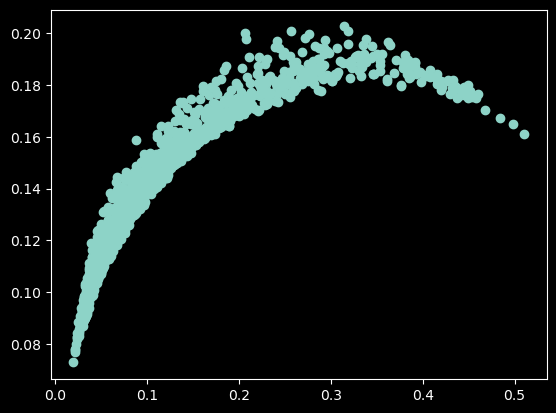

In [164]:
matplotlib.rcParams['figure.facecolor'] = 'black'
matplotlib.rcParams['savefig.facecolor'] = 'black'



plt.scatter(samples["probs_latent"].mean(axis=0), samples["probs_latent"].std(axis=0))


In [147]:
@jax.jit
def triu_to_mat(triu):
    mat = jnp.zeros((num_nodes, num_nodes))
    mat = mat.at[np.triu_indices(n=num_nodes, k=1)].set(triu)
    return mat + mat.T

@jax.jit
def compute_deg(triu):
    mat = triu_to_mat(triu)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg)



In [165]:
post_degs = vmap_deg(post_triu)
print(post_degs.shape)

print(post_degs.mean(axis=0), post_degs.std(axis=0))

(10000, 61)
[2.1483998 7.1698    6.3475    7.0006    7.9823    6.0427    9.3749
 8.144899  5.8606997 5.3622    8.2602    7.9287    8.5492    4.6528997
 7.1112    5.8898    8.4875    6.7752    9.206699  6.6008997 8.9894
 3.2038    9.0352    8.3762    7.8763    9.473     5.1769    8.2175
 8.3924    8.9327    9.5055    6.2212996 8.8933    9.6453    8.2722
 6.811     8.0097    4.2405    8.9091    6.587     6.1004    6.1092997
 4.4549    9.7094    6.7667    9.0449    8.4005995 6.7553    3.8269
 8.3632    9.177     6.6113    4.4349    3.5744    4.2046    7.1124997
 4.856     6.1261997 3.1188    3.1545    3.4266   ] [1.4462286 2.4141185 2.3350682 2.441557  2.50599   2.2602825 2.6970632
 2.5606062 2.2198415 2.160558  2.6002107 2.5264633 2.5997653 2.0353923
 2.4889827 2.2515895 2.5557864 2.3726916 2.64098   2.3147397 2.6599789
 1.7461001 2.6143758 2.5353253 2.514756  2.6690578 2.1331213 2.4919457
 2.5781043 2.6268938 2.609975  2.278536  2.5777733 2.7422779 2.5781598
 2.377368  2.5396862 1.97156

0.44742745
3.704421


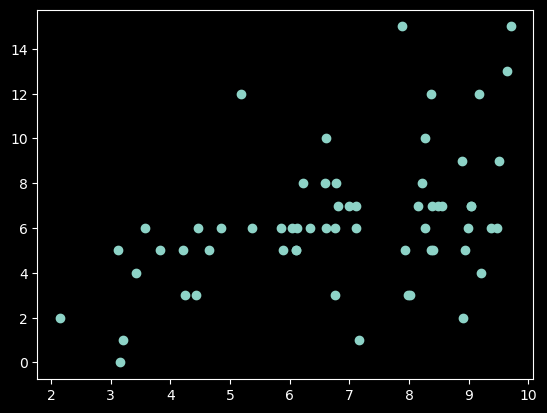

In [166]:


true_mat = triu_to_mat(latent_layer_triu)
true_deg = jnp.sum(true_mat, axis=1)

plt.scatter(post_degs.mean(axis=0), true_deg)

print(jnp.corrcoef(post_degs.mean(axis=0), true_deg)[0,1])
degs_rmse = jnp.sqrt(jnp.mean((post_degs - true_deg)**2))
print(degs_rmse)

In [105]:
import seaborn as sns

def plot_heatmaps(posterior_probs, true_values):
    """
    Plot two heatmaps side by side:
    - Left: Posterior mean probabilities of edges in the latent adjacency.
    - Right: True adjacency matrix of the latent layer.
    
    Arguments:
    - posterior_probs: n x n matrix of posterior mean probabilities (values in [0,1]).
    - true_values: n x n binary adjacency matrix (values in {0,1}).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Heatmap of posterior mean probabilities
    sns.heatmap(posterior_probs, ax=axes[0], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[0].set_title("Posterior Mean Probabilities")
    
    # Heatmap of true adjacency matrix
    sns.heatmap(true_values, ax=axes[1], cmap="coolwarm", vmin=0, vmax=1, annot=False)
    axes[1].set_title("True Adjacency Matrix")
    
    plt.tight_layout()
    plt.show()

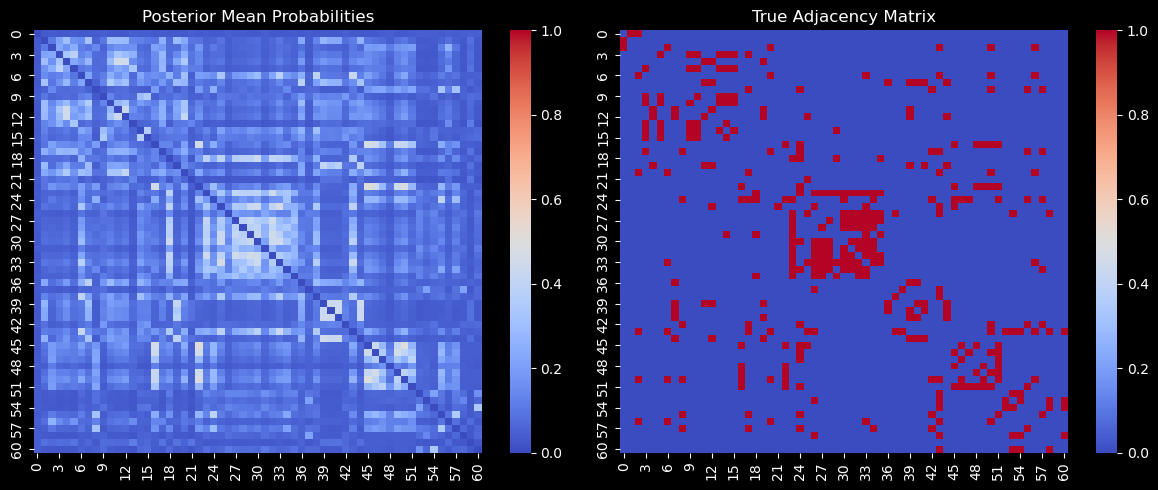

In [167]:
post_probs_mat = triu_to_mat(post_probs)
plot_heatmaps(post_probs_mat, true_mat)

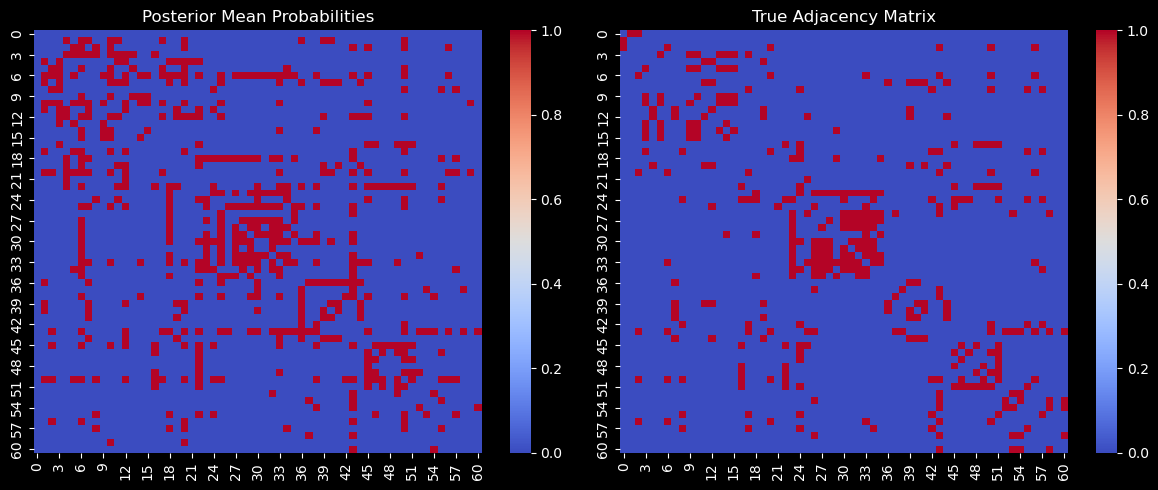

In [127]:
# aggreagted network by either 'OR' or 'AND' for all edges in observed layers

def aggregate_edges(triu_vals, method="or"):
    """
    Aggregate edges from multiple layers into a single adjacency matrix.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - method: "or" or "and" for how to aggregate edges.
    
    Returns:
    - n x n adjacency matrix of aggregated edges.
    """
    if method == "or":
        return jnp.any(triu_vals, axis=0)
    elif method == "and":
        return jnp.all(triu_vals, axis=0)
    else:
        raise ValueError("Invalid aggregation method. Must be 'or' or 'and'.")
    
agg_or = aggregate_edges(obs_layers_triu, method="or")
agg_and = aggregate_edges(obs_layers_triu, method="and")

plot_heatmaps(triu_to_mat(agg_or), true_mat)

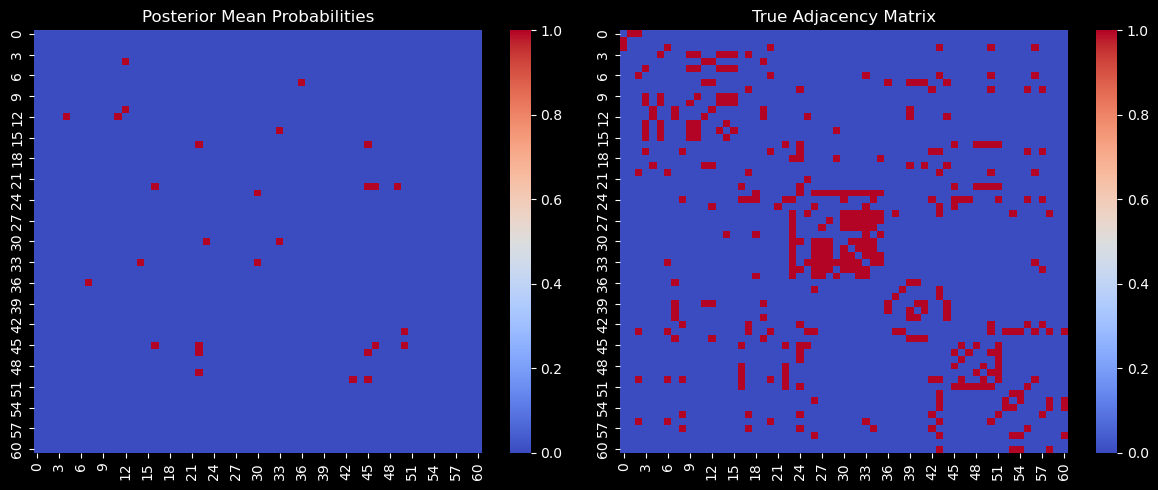

In [128]:
plot_heatmaps(triu_to_mat(agg_and), true_mat)

In [ ]:
@jax.jit
def cut_post_log_density(triu_vals, post_probs):
    """
    Compute the log density of the posterior probabilities for the observed edges.
    
    Arguments:
    - triu_vals: n_layers x n choose 2 array of edge values.
    - post_probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - log likelihood of the observed edges under the posterior probabilities.
    """
    return jnp.sum(triu_vals * jnp.log(post_probs) + (1 - triu_vals) * jnp.log1p(post_probs))

vmap_post_density = jax.vmap(cut_post_log_density, in_axes=(0, None))

def max_post_net(triu_samps, probs):
    """
    Find the network with the highest posterior density.
    
    Arguments:
    - triu_samps: n_samples x n choose 2 array of posterior samples.
    - probs: n choose 2 array of posterior probabilities.
    
    Returns:
    - n choose 2 array of the network with the highest posterior density.
    """
    log_densities = vmap_post_density(triu_samps, probs)
    max_idx = jnp.argmax(log_densities)
    return triu_samps[max_idx]




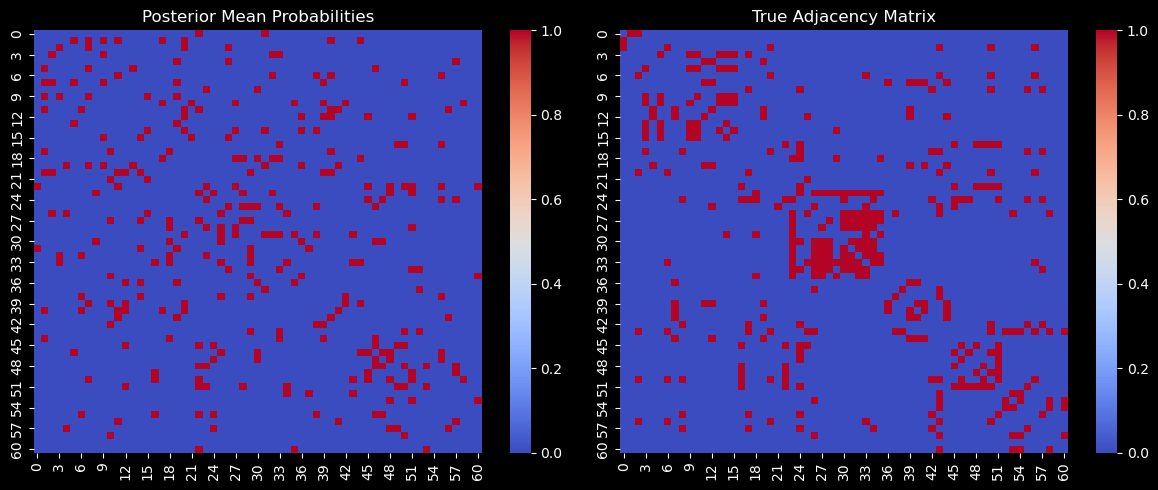

In [171]:
max_post_triu = max_post_net(post_triu, post_probs)

plot_heatmaps(triu_to_mat(max_post_triu), true_mat)

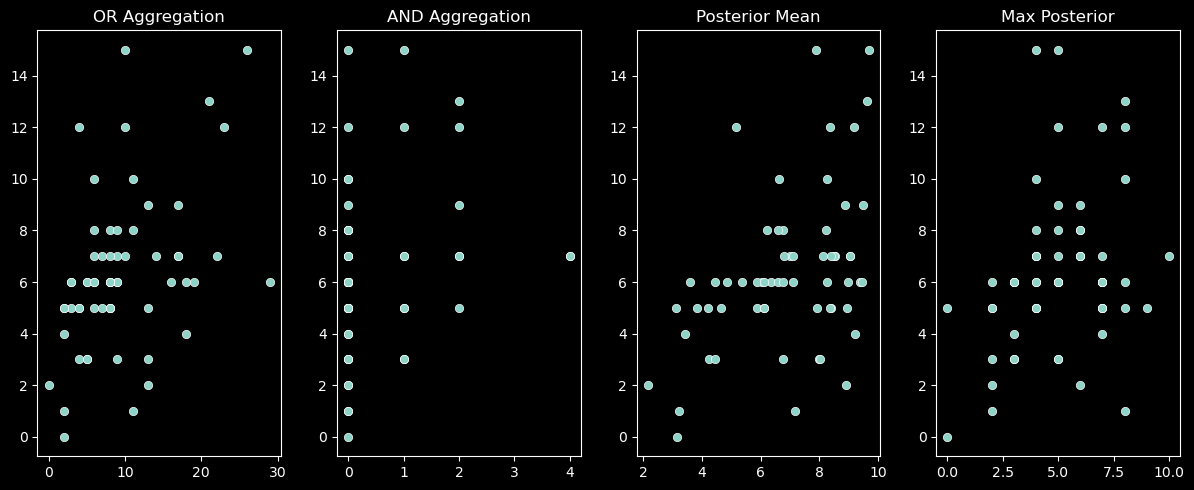

or~true cor 0.4189215
and~true cor 0.24504355
post~true cor 0.44742745
max_post~true cor 0.30260774
or~true rmse 6.6357203
and~true rmse 6.5761614
post~true rmse 2.853422
max_post~true rmse 3.4068396


In [169]:
agg_or_degs = compute_deg(agg_or)
agg_and_degs = compute_deg(agg_and)
max_post_deg = compute_deg(max_post_triu)

fig, axs = plt.subplots(1, 4, figsize=(12, 5))

sns.scatterplot(x=agg_or_degs, y=true_deg, ax=axs[0])
axs[0].set_title("OR Aggregation")

sns.scatterplot(x=agg_and_degs, y=true_deg, ax=axs[1])
axs[1].set_title("AND Aggregation")

sns.scatterplot(x=post_degs.mean(axis=0), y=true_deg, ax=axs[2])
axs[2].set_title("Posterior Mean")

sns.scatterplot(x=max_post_deg, y=true_deg, ax=axs[3])
axs[3].set_title("Max Posterior")

plt.tight_layout()
plt.show()

print("or~true cor", jnp.corrcoef(agg_or_degs, true_deg)[0,1])
print("and~true cor", jnp.corrcoef(agg_and_degs, true_deg)[0,1])
print("post~true cor", jnp.corrcoef(post_degs.mean(axis=0), true_deg)[0,1])
print("max_post~true cor", jnp.corrcoef(max_post_deg, true_deg)[0,1])

print("or~true rmse", jnp.sqrt(jnp.mean((agg_or_degs - true_deg)**2)))
print("and~true rmse", jnp.sqrt(jnp.mean((agg_and_degs - true_deg)**2)))
print("post~true rmse", jnp.sqrt(jnp.mean((post_degs.mean(axis=0) - true_deg)**2)))
print("max_post~true rmse", jnp.sqrt(jnp.mean((max_post_deg - true_deg)**2)))

In [251]:
# generate synthetic data
import Simulations.data_gen as dg
import src.utils as utils

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality

    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)

    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)

    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    # return degrees / (n - 1)
    return degrees / (n - 1)

@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = triu_to_mat(triu_star)
    deg_cen = degree_centrality(mat_star)
    return utils.weighted_exposures(Z, deg_cen, mat_star)

vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))

def CAR_cov(triu_vals, sig_inv, rho, n):
    # Cov(Y) = \Sigma = sig_inv * (D - rho*A)^-1
    # So precision = \Sigma^{-1} = (1/sig_inv) * (D - rho*A)
    adj_mat = triu_to_mat(triu_vals)
    degs_diag = jnp.sum(adj_mat, axis=1) * jnp.eye(n) 
    # Compute precision matrix Sigma^{-1}
    precis_ = sig_inv * (degs_diag - rho * adj_mat) + 1e-3*jnp.eye(n)
    # Return Sigma
    return jnp.linalg.inv(precis_)


def generate_data(key, n, triu_star, eta, rho, sig_inv):
    z_key, y_key = random.split(key)
    Z = dg.generate_treatments(rng=z_key, n=n)
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, expos]))
    mean_y = df_nodes @ eta
    # y_cov = CAR_cov(triu_star, sig_inv, rho, n)
    y_cov = random.normal(y_key, shape=(n,))*sig_inv 
    # print("y_cov is positive definite?", jnp.all(jnp.linalg.eigvals(y_cov) > 0))

    # y = random.multivariate_normal(y_key, mean_y, y_cov)
    y = mean_y + y_cov

    return {
        "Z": Z,
        "true_exposures": expos,
        "Y": y,
    }

In [244]:

ETA = jnp.array([-1, 3, 3])
SIG_INV = 0.5
RHO = 0.5

rng_key, _ = random.split(rng_key)
true_data = generate_data(key=rng_key,
                        n=num_nodes,
                        triu_star=latent_layer_triu,
                        eta=ETA,
                        rho=RHO,
                        sig_inv=SIG_INV)

print(true_data["Y"].shape)

(61,)


(array([ 7.,  5., 12.,  7.,  7.,  9.,  6.,  2.,  4.,  2.]),
 array([0.        , 0.11499999, 0.22999999, 0.345     , 0.45999998,
        0.57499999, 0.69      , 0.80500001, 0.91999996, 1.03499997,
        1.14999998]),
 <BarContainer object of 10 artists>)

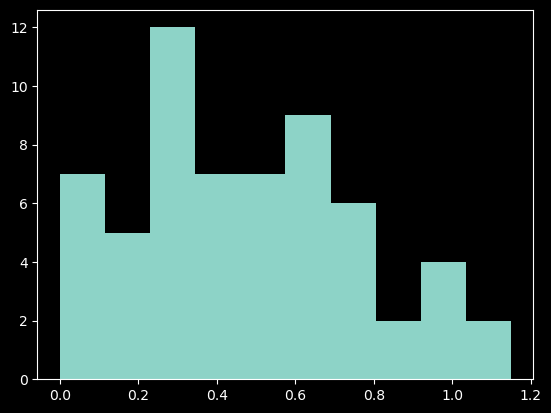

In [245]:
plt.hist(true_data["true_exposures"], bins=10)

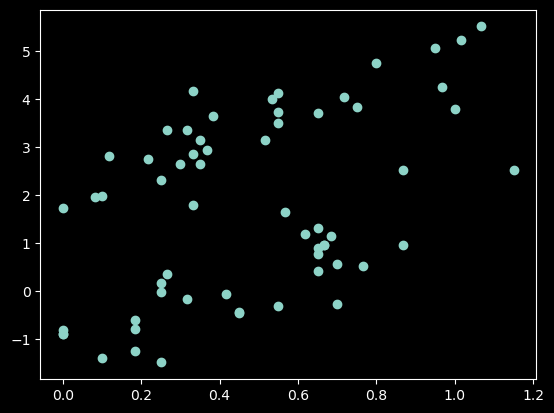

In [246]:
plt.scatter(true_data["true_exposures"], true_data["Y"])

In [247]:
def outcome_model(Z, exposures, Y):
    n = Z.shape[0]
    with numpyro.plate("eta_plate", 3):
        eta = numpyro.sample("eta", dist.Normal(0.0, 3.0))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))
    mean_y = jnp.transpose(jnp.stack([jnp.ones(n), Z, exposures])) @ eta

    numpyro.sample("Y", dist.Normal(mean_y, sig_inv), obs=Y)

In [255]:
import src.Models as models

# run plugin model with true data

obs_df_node = jnp.transpose(jnp.stack([jnp.ones(num_nodes), true_data["Z"], true_data["true_exposures"]]))

rng_key, _ = random.split(rng_key)
plugin_kernel = NUTS(outcome_model)
plugin_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)

plugin_mcmc.run(rng_key, 
                Z=true_data["Z"],
                exposures=true_data["true_exposures"],
                Y=true_data["Y"])

plugin_mcmc.print_summary()

plugin_samples = plugin_mcmc.get_samples()
print(plugin_samples.keys())


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -1.14      0.16     -1.14     -1.40     -0.88   4977.56      1.00
    eta[1]      3.14      0.15      3.14      2.90      3.38   7073.56      1.00
    eta[2]      2.91      0.25      2.91      2.48      3.31   5591.90      1.00
   sig_inv      0.56      0.05      0.56      0.47      0.64   6630.12      1.00

Number of divergences: 0
dict_keys(['eta', 'sig_inv'])


In [267]:
rng_key, _ = random.split(rng_key)
new_z = dg.generate_treatments(rng=rng_key, n=num_nodes)
new_expos = compute_exposures(latent_layer_triu, new_z)
new_estimand = jnp.transpose(jnp.stack([jnp.ones(num_nodes), new_z, new_expos])) @ ETA
print(new_estimand.mean(), new_estimand.std(), new_estimand.min(), new_estimand.max())

2.6795082 1.6714424 -0.65 5.4000006


In [268]:
from numpyro.infer import Predictive

plugin_predictive = Predictive(outcome_model, plugin_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
plugin_samples_predictive = plugin_predictive(rng_key, 
                                            Z=new_z,
                                            exposures=new_expos,
                                            Y=None)

plugin_estimates = plugin_samples_predictive["Y"]
print(plugin_estimates.shape, plugin_estimates.mean())



(10000, 61) 2.5793557


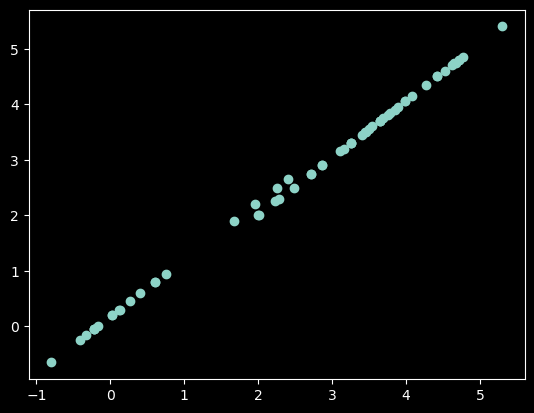

In [269]:
plt.scatter(plugin_estimates.mean(axis=0), new_estimand)

In [260]:
# run with posterior exposures

# get posterior exposures
post_expos = vmap_compute_exposures(post_triu, new_z).mean(axis=0)

# run mcmc
rng_key, _ = random.split(rng_key)
post_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
post_mcmc.run(rng_key, 
                Z=true_data["Z"],
                exposures=post_expos,
                Y=true_data["Y"])

post_mcmc.print_summary()

post_samples = post_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.04      0.46     -0.05     -0.79      0.71   4450.39      1.00
    eta[1]      3.15      0.27      3.15      2.73      3.61   6577.85      1.00
    eta[2]      0.74      1.11      0.76     -1.06      2.58   4572.14      1.00
   sig_inv      1.04      0.10      1.03      0.89      1.20   5918.95      1.00

Number of divergences: 0


In [270]:
# post_estimand with true model

post_expos_new_z = vmap_compute_exposures(post_triu, new_z).mean(axis=0)

post_predictive = Predictive(outcome_model, post_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
post_samples_predictive = post_predictive(rng_key, 
                                            Z=new_z,
                                            exposures=post_expos_new_z,
                                            Y=None)
post_estimates = post_samples_predictive["Y"]
print(post_estimates.shape, post_estimates.mean())

(10000, 61) 2.5969684


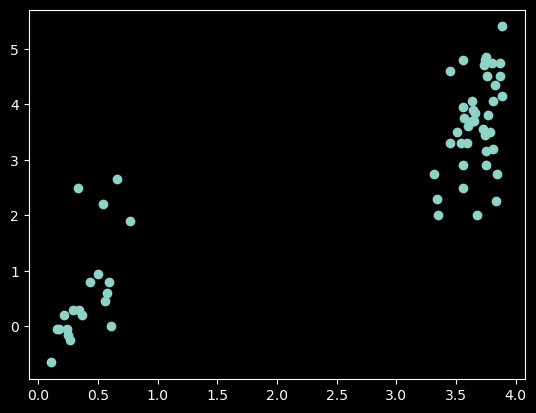

In [271]:
plt.scatter(post_estimates.mean(axis=0), new_estimand)

In [272]:
utils.compute_error_stats(post_estimates=plugin_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(2.57936, dtype=float32),
 'median': Array(2.99441, dtype=float32),
 'true': Array(2.6795099, dtype=float32),
 'bias': Array(-0.10015, dtype=float32),
 'std': Array(0.10651, dtype=float32),
 'RMSE': Array(0.1462, dtype=float32),
 'RMSE_rel': Array(0.05456, dtype=float32),
 'MAE': Array(0.10027999, dtype=float32),
 'MAPE': Array(2753.9333, dtype=float32),
 'q025': Array(2.3700535, dtype=float32),
 'q975': Array(2.7900262, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(1., dtype=float32),
 'w_dist': 1.0}

In [273]:
utils.compute_error_stats(post_estimates=post_estimates,
                          true_estimand=new_estimand,
                          wasserstein_dist=1.0)


{'mean': Array(2.5969698, dtype=float32),
 'median': Array(2.94468, dtype=float32),
 'true': Array(2.6795099, dtype=float32),
 'bias': Array(-0.08254, dtype=float32),
 'std': Array(0.385, dtype=float32),
 'RMSE': Array(0.39374, dtype=float32),
 'RMSE_rel': Array(0.14694999, dtype=float32),
 'MAE': Array(0.60306996, dtype=float32),
 'MAPE': Array(9704.042, dtype=float32),
 'q025': Array(1.8283864, dtype=float32),
 'q975': Array(3.3253968, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(0.98361, dtype=float32),
 'w_dist': 1.0}

In [274]:
# now with agg_or network

agg_or_expos = compute_exposures(agg_or, new_z)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_or_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_or_mcmc.run(rng_key, 
                Z=true_data["Z"],
                exposures=agg_or_expos,
                Y=true_data["Y"])

agg_or_mcmc.print_summary()

agg_or_samples = agg_or_mcmc.get_samples()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.19      0.24     -0.19     -0.57      0.23   5769.75      1.00
    eta[1]      3.04      0.26      3.04      2.59      3.45   6473.11      1.00
    eta[2]      0.29      0.11      0.29      0.10      0.46   6224.84      1.00
   sig_inv      0.99      0.09      0.98      0.83      1.13   6776.55      1.00

Number of divergences: 0


In [275]:
# predictive estimate

agg_or_post_expos = compute_exposures(agg_or, new_z)

agg_or_predictive = Predictive(outcome_model, agg_or_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
agg_or_samples_predictive = agg_or_predictive(rng_key, 
                                            Z=new_z,
                                            exposures=agg_or_post_expos,
                                            Y=None)
agg_or_estimates = agg_or_samples_predictive["Y"]
print(agg_or_estimates.shape, agg_or_estimates.mean())

utils.compute_error_stats(post_estimates=agg_or_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)

(10000, 61) 2.3531165


{'mean': Array(2.3531199, dtype=float32),
 'median': Array(2.72737, dtype=float32),
 'true': Array(2.6795099, dtype=float32),
 'bias': Array(-0.32639, dtype=float32),
 'std': Array(0.18654999, dtype=float32),
 'RMSE': Array(0.37594, dtype=float32),
 'RMSE_rel': Array(0.14029999, dtype=float32),
 'MAE': Array(0.65446, dtype=float32),
 'MAPE': Array(8856.461, dtype=float32),
 'q025': Array(1.9847116, dtype=float32),
 'q975': Array(2.7188723, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(0.96721, dtype=float32),
 'w_dist': 1.0}

In [276]:
# agg_and 

agg_and_expos = compute_exposures(agg_and, new_z)

# run mcmc
rng_key, _ = random.split(rng_key)
agg_and_mcmc = MCMC(plugin_kernel, num_warmup=2000, num_samples=2500, num_chains=4)
agg_and_mcmc.run(rng_key, 
                Z=true_data["Z"],
                exposures=agg_and_expos,
                Y=true_data["Y"])

agg_and_mcmc.print_summary()

agg_and_samples = agg_and_mcmc.get_samples()


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      0.22      0.19      0.22     -0.08      0.52   6276.24      1.00
    eta[1]      3.15      0.26      3.15      2.73      3.59   6345.35      1.00
    eta[2]      2.54      2.49      2.55     -1.54      6.61   8433.81      1.00
   sig_inv      1.03      0.10      1.02      0.87      1.19   8639.31      1.00

Number of divergences: 0


In [277]:
# predictive estimate

agg_and_post_expos = compute_exposures(agg_and, new_z)

agg_and_predictive = Predictive(outcome_model, agg_and_samples, return_sites=["Y"])
rng_key, _ = random.split(rng_key)
agg_and_samples_predictive = agg_and_predictive(rng_key, 
                                            Z=new_z,
                                            exposures=agg_and_post_expos,
                                            Y=None)
agg_and_estimates = agg_and_samples_predictive["Y"]
print(agg_and_estimates.shape, agg_and_estimates.mean())

utils.compute_error_stats(post_estimates=agg_and_estimates,
                            true_estimand=new_estimand,
                            wasserstein_dist=1.0)


(10000, 61) 2.37157


{'mean': Array(2.3715699, dtype=float32),
 'median': Array(2.73634, dtype=float32),
 'true': Array(2.6795099, dtype=float32),
 'bias': Array(-0.30794, dtype=float32),
 'std': Array(0.19332999, dtype=float32),
 'RMSE': Array(0.3636, dtype=float32),
 'RMSE_rel': Array(0.1357, dtype=float32),
 'MAE': Array(0.6933, dtype=float32),
 'MAPE': Array(4071.3306, dtype=float32),
 'q025': Array(1.9858685, dtype=float32),
 'q975': Array(2.7482026, dtype=float32),
 'covering': Array(True, dtype=bool),
 'mean_ind_cover': Array(0.96721, dtype=float32),
 'w_dist': 1.0}